In [251]:
# install pytesseract
%pip install opencv-python matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


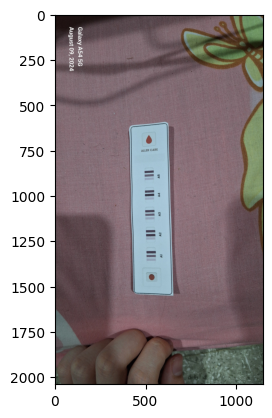

In [1]:
# organize imports
import numpy as np
import cv2
from matplotlib import pyplot as plt
from pathlib import Path

brand_text = 'ALLERCARE'
SAMPLE_PATH = Path.cwd() / 'data' / 'real4.jpg'
img = cv2.imread(SAMPLE_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if img.shape[0] < img.shape[1]:
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    
img = cv2.resize(img, (1148, 2040))
plt.imshow(img)

In [2]:
# convert to grayscale
def get_device_image(img):
    edged = cv2.Canny(img, 170, 490
                      )
    # sharpen the image
    # Apply adaptive threshold
    thresh = cv2.adaptiveThreshold(edged, 255, 1, 1, 11, 2)

    # apply some dilation and erosion to join the gaps - change iteration to detect more or less area's
    thresh = cv2.dilate(thresh,None,iterations = 55)
    thresh = cv2.erode(thresh,None,iterations = 55)
    plt.imshow(thresh)
    plt.show()

    # Find the contours
    contours,_ = cv2.findContours(thresh,
                                            cv2.RETR_EXTERNAL,
                                            cv2.CHAIN_APPROX_SIMPLE)
    
    # For each contour, find the bounding rectangle and draw it
    boxes = [cv2.boundingRect(cnt) for cnt in contours]
    max_box = max(boxes, key=lambda x: x[2]*x[3])
    x, y, w, h = max_box
    show_img = img[y:y+h,x:x+w, :]
        
    if w > h:
        show_img = np.rot90(show_img)
        
    plt.imshow(show_img)
    
    
    cntr = max(contours, key=cv2.contourArea)  
    peri = cv2.arcLength(cntr, True)
    approx = cv2.approxPolyDP(cntr, 0.05 * peri, True)
	# draw the approximated contour on the image
    output = img.copy()
    cv2.drawContours(output, [approx], -1, (0, 255, 0), 3)
    plt.imshow(output)
    plt.show()

    cont = np.array(approx).reshape(-1, 2)
    middle_point = np.mean(cont, axis=0)
    for c in cont:
        if c[0] < middle_point[0]:
            if c[1] < middle_point[1]:
                top_left = c
            else:
                bottom_left = c
        else:
            if c[1] < middle_point[1]:
                top_right = c
            else:
                bottom_right = c
    # find most left and right point/ top and bottom point
    

    w, h = 130, 475
    corners = np.array([top_left, top_right, bottom_left, bottom_right], dtype = np.float32)
    transformed_shape = np.array([[0, 0], [w, 0], [0, h],[w, h]], dtype = np.float32)
    perspective_transform = cv2.getPerspectiveTransform(corners,transformed_shape)
    img_Output = cv2.warpPerspective(img,perspective_transform,(w, h))
    plt.imshow(img_Output)
    plt.show()

    top = int(0.25 * h)
    bottom = int(0.83 * h)
    num = 5

    device = img_Output[top:bottom, ...].copy()
    
    fig, axs = plt.subplots(1, num, figsize=(10, 10))
    
    strip_height = (bottom - top) // num
    strips_img = []
    for i, ax in enumerate(axs):
        strip = device[i*strip_height:(i+1)*strip_height, ...]
        strips_img.append(strip)
        ax.imshow(strip)
    plt.show()
    return strips_img

In [3]:
def enhance_image(img):
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(4,4))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return enhanced_img

def get_line(ori_strip):
    ori_strip = ori_strip[:, ori_strip.shape[1]//3:(ori_strip.shape[1]* 2) //3, :]
    ori_strip = cv2.fastNlMeansDenoisingColored(ori_strip, None, 10, 10, 2, 3) 

    # strip = enhance_image(ori_strip)
    strip = cv2.cvtColor(ori_strip, cv2.COLOR_RGB2GRAY)
    # adaptive thresholding
    strip = cv2.adaptiveThreshold(strip, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 8)
    # otsu binarization
    # strip = cv2.threshold(strip, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    # apply some dilation and erosion to join the gaps - change iteration to detect more or less area's
    # apply morphology open with square kernel to remove small white spots
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    strip = cv2.morphologyEx(strip, cv2.MORPH_OPEN, kernel)

    # apply morphology close with horizontal rectangle kernel to fill horizontal gap
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    strip = cv2.morphologyEx(strip, cv2.MORPH_CLOSE, kernel)

    plt.imshow(strip)
    # not operation
    strip = cv2.bitwise_not(strip)
    
    # Find the contours
    contours,hierarchy = cv2.findContours(strip,
                                            cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE,
    )

    x_offset = 2
    y_offset = 1
    # For each contour, find the bounding rectangle and draw it
    color_lines = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        color_line = ori_strip[max(0, y - y_offset):min(ori_strip.shape[0],y + h + y_offset), max(x - x_offset , 0): min(ori_strip.shape[1], x + w + x_offset)]
        color_lines.append([color_line, np.array([x,y,w,h])])
        # plt.imshow(color_line)
        # plt.show()
    if len(color_lines) == 2: # only get 2 lines then it is missing the middle line
        x,y,w,h = (color_lines[0][1] + color_lines[1][1]) // 2
        color_line = ori_strip[max(0, y - y_offset):min(ori_strip.shape[0],y + h + y_offset), max(x - x_offset , 0): min(ori_strip.shape[1], x + w + x_offset)]
        color_lines.insert(1, [color_line, np.array([x,y,w,h])])
    elif len(color_lines) > 3:
        areas = [line[1][2] * line[1][3] for line in color_lines]
        idx = sorted(np.argsort(areas)[::-1][:3])
        color_lines = [color_lines[i] for i in idx]
    
    for line in color_lines:
        plt.imshow(line[0])
        plt.show()
    print(len(color_lines))
    return [line[0] for line in color_lines]

In [4]:

def get_lightness(color):
    return 0.2 * color[0] + 0.2 * color[1] + 0.7 * color[2]
def get_approx_colors(color_lines):
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    average_colors = []
    for i,color_strip in enumerate(color_lines):
        # get weights average of top 10 color
        color_strip = color_strip.reshape(-1, 3)
        # count the color using np.unique
        color_strip_filtered = color_strip[color_strip[:, 2] < 190] # remove white-blue color
        if len(color_strip_filtered) <= 3:
            average_colors.append(min(color_strip, key=lambda x: get_lightness(x)))
        else:
            color, count = np.unique(color_strip_filtered, axis=0, return_counts=True)

            # get the top 10 color
            top_color = np.argsort(count)[::-1][:3]
            weights = count[top_color]
            top_color = color[top_color]
            # get the average color
            average_color = np.average(top_color, axis=0, weights=weights)
            average_colors.append(average_color)
            axs[i].imshow(average_color.astype(np.uint8).reshape(1, 1, 3))
    plt.show()
    return average_colors

In [5]:
def rgb_projection_distance(average_colors):
    average_colors = 1 - np.array(average_colors) / 255
    
    measure_vector = average_colors[1] - average_colors[0]
    scale_vector = average_colors[2] - average_colors[0]
    measurement_scale = np.dot(scale_vector, measure_vector) / np.linalg.norm(scale_vector) ** 2 # projection of measure_vector to scale_vector then inverse it to get the scale
    print(f'{measurement_scale=}')
    return measurement_scale

def rgb_distance(average_colors):
    average_colors = 1 - np.array(average_colors) / 255
    
    measure_vector = average_colors[1] - average_colors[0]
    scale_vector = average_colors[2] - average_colors[0]
    measurement_scale = np.linalg.norm(measure_vector) / np.linalg.norm(scale_vector)
    # print(f'{measurement_scale=}')
    return measurement_scale

In [6]:
def run_process(img):
    measurements = []
    strips_img = get_device_image(img)[::-1]
    for i,strip in enumerate(strips_img, start = 1):
        color_lines = get_line(strip)
        average_colors = get_approx_colors(color_lines)
        measure = rgb_projection_distance(average_colors)
        print(f'{i}\'s strip: {measure:.3f}')
        measurements.append(measure)
    
    # binning 0.0-0.2 = 1, 0.2-0.4 = 2, 0.4-0.6 = 3, 0.6-0.8 = 4, 0.8-1.0 = 5
    for i, measure in enumerate(measurements):
        if measure < 0.2:
            measurements[i] = 1
        elif measure < 0.4:
            measurements[i] = 2
        elif measure < 0.6:
            measurements[i] = 3
        elif measure < 0.8:
            measurements[i] = 4
        else:
            measurements[i] = 5
    return measurements

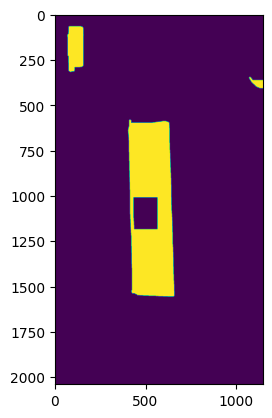

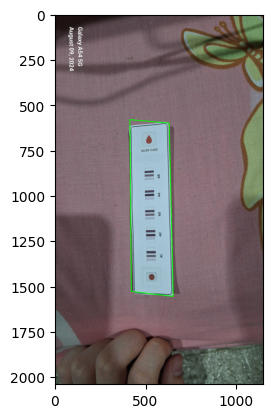

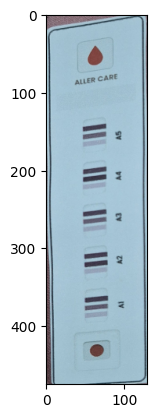

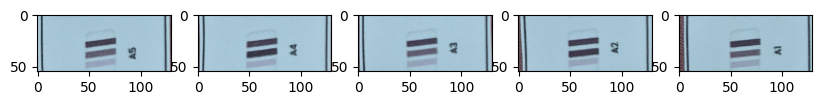

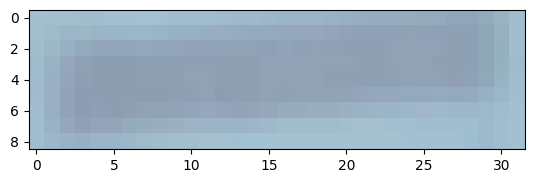

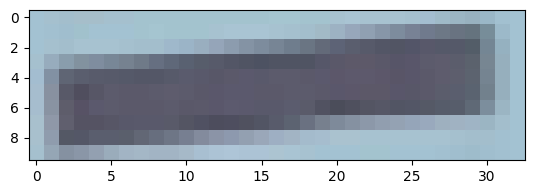

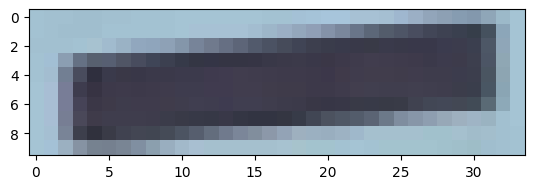

3


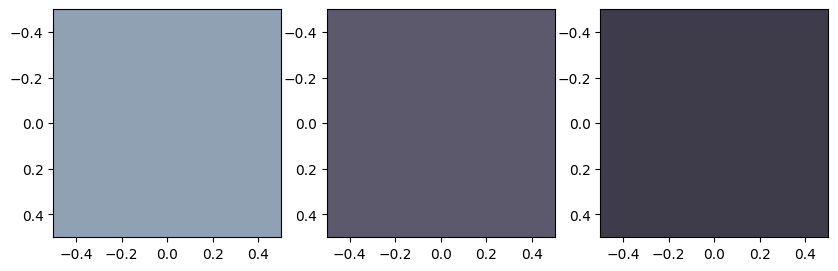

measurement_scale=np.float64(0.6848965020241777)
1's strip: 0.685


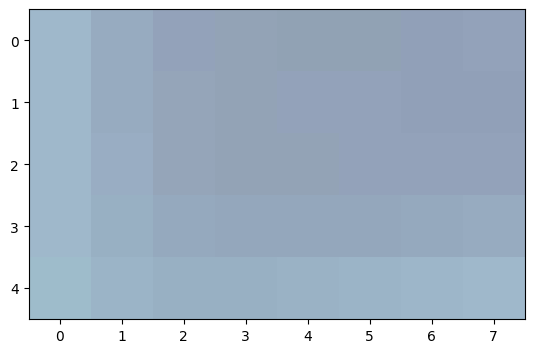

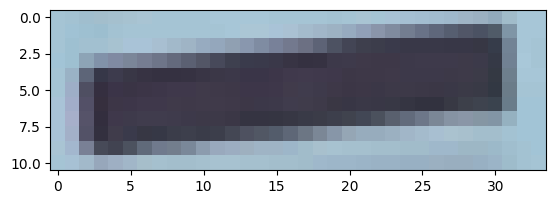

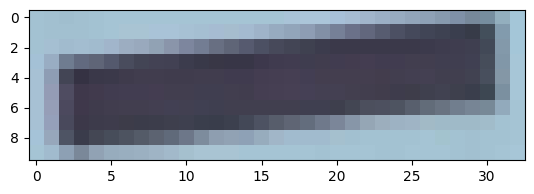

3


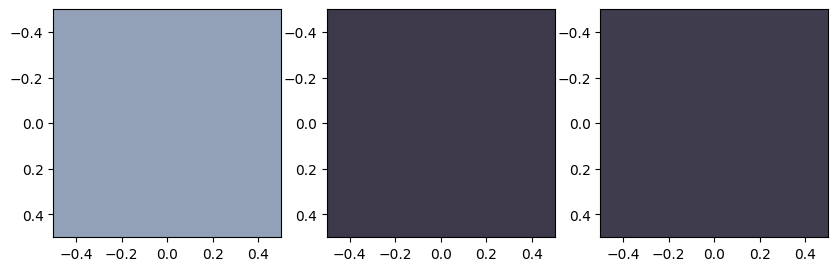

measurement_scale=np.float64(1.024449279521321)
2's strip: 1.024


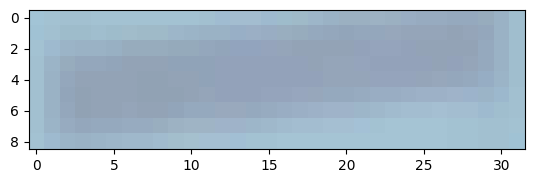

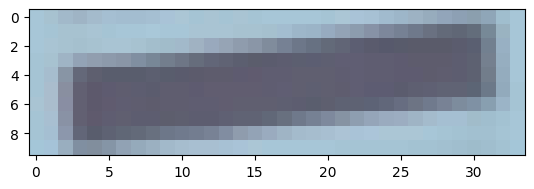

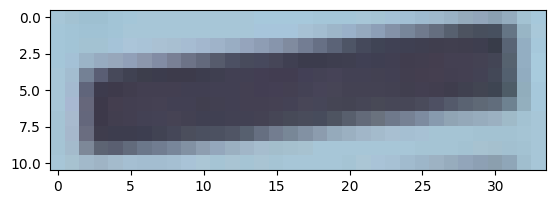

3


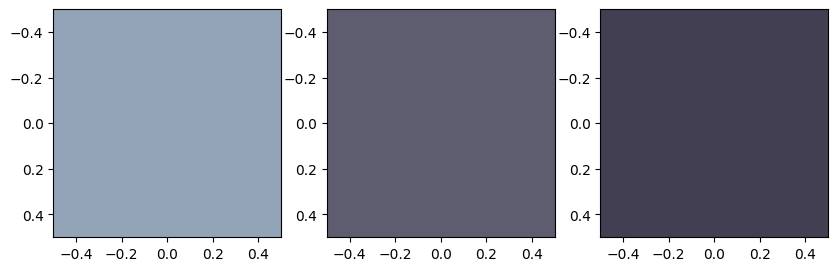

measurement_scale=np.float64(0.6898798477747455)
3's strip: 0.690


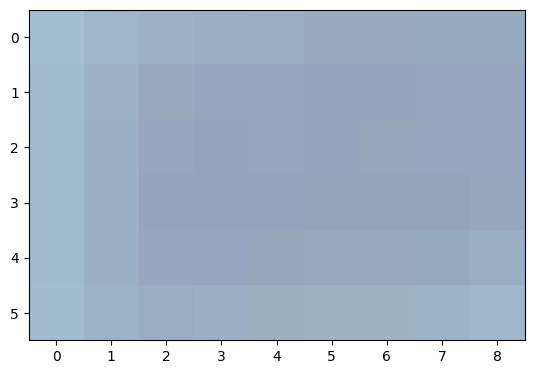

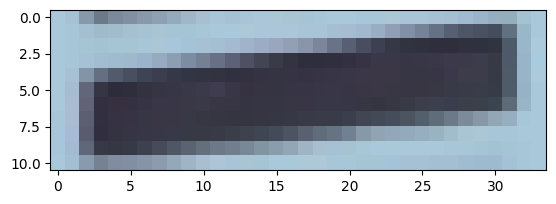

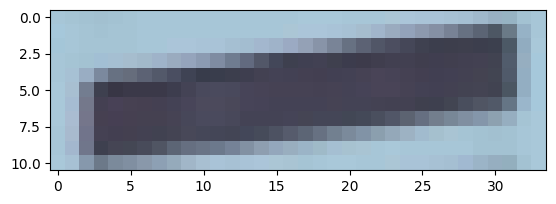

3


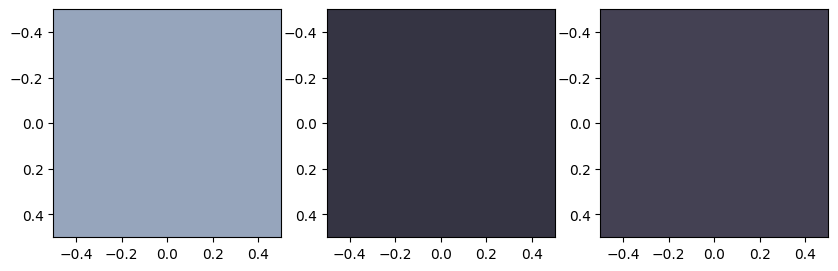

measurement_scale=np.float64(1.1528797545964136)
4's strip: 1.153


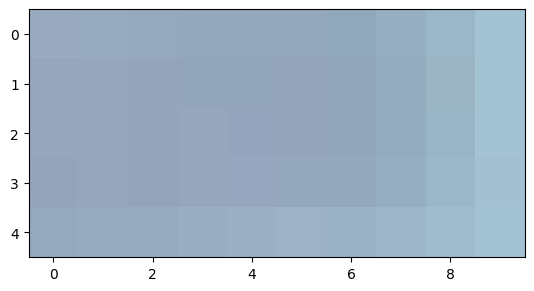

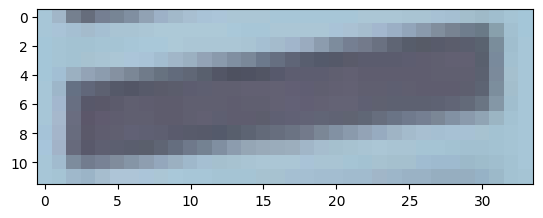

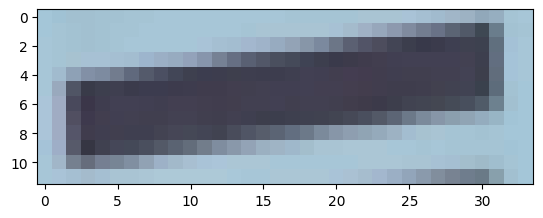

3


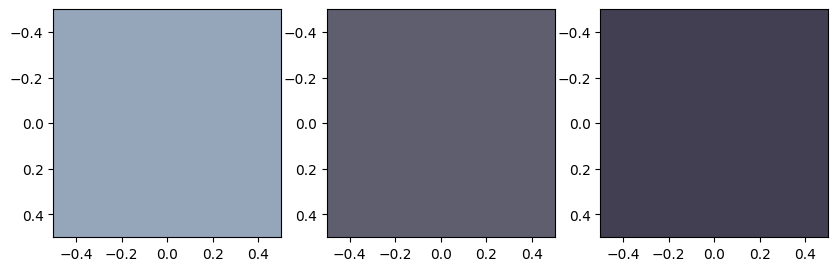

measurement_scale=np.float64(0.687542600424446)
5's strip: 0.688
[4, 5, 4, 5, 4]


In [7]:
print(run_process(img))